In [57]:
!pip install pyldavis
!pip install torch
!pip install torchtext
!pip install sentence_transformers
!pip install langid
!pip install datasets
!pip install transformers
!pip install bertopic
!pip install gensim

In [58]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
# import pyLDAvis.gensim_models
import langid
import random

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

# Agenda

1. [Load and Preprocess Data](#Load_and_Preprocess_Data)
2. [Clustering Algorithms](#Clustering_Algorithms)
3. [Dimensionality Reduction](#Dimensionality_Reduction) 
3. [Text Embeddings clustering](#Text_Embeddings_clustering)
4. [Topic Modelling](#Topic_Modelling)
4. [Homework](#Homework)

<a id='Load_and_Preprocess_Data'></a>
# Load and Preprocess Data

In [59]:
df = pd.read_csv("/kaggle/input/kyivchennels/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [60]:
df.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [61]:
df.shape

(31182, 4)

In [62]:
df.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [63]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

In [64]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang

# df["lang"] = df["content"].apply(detect_language)
df["lang"].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

In [65]:
df[df["lang"] == 'de']

channelname                Date  \
6250  maxbakhmatov 2023-08-17 15:11:50   
7565   tsegla_news 2023-08-21 06:41:37   

                                                content lang  
6250                                       Bentley Kraz   de  
7565  https://life.liga.net/all/news/zastroyschik-so...   de

In [66]:
df[df["lang"] == 'mn']

channelname                Date  \
60     poznyakyosokorkykharkivskiy 2023-08-01 08:40:25   
1397                   darnicalive 2023-08-04 18:42:20   
1632                  ushkiklichko 2023-08-04 07:44:04   
2867               lossolomas_kyiv 2023-08-08 14:24:37   
2928                  ushkiklichko 2023-08-08 14:23:22   
3320                  ushkiklichko 2023-08-09 04:05:56   
3405                  ushkiklichko 2023-08-09 05:50:08   
5017                 khreschatyk36 2023-08-14 03:11:16   
6475                   semenovatut 2023-08-18 07:13:25   
7865                  ushkiklichko 2023-08-22 04:45:56   
8032   poznyakyosokorkykharkivskiy 2023-08-23 14:09:58   
8888                   semenovatut 2023-08-25 08:38:39   
9270   poznyakyosokorkykharkivskiy 2023-08-26 22:49:42   
10282            kyivpastrans_live 2023-08-29 13:28:17   
10397              lossolomas_kyiv 2023-08-29 20:25:51   
12112                 ushkiklichko 2023-09-03 07:34:53   
13467              lossolomas_kyiv 2023-09-07 16:57:49   
19054  poznyakyosokorkykharkivskiy 2023-09-22 14:43:17   
20034                 ushkiklichko 2023-09-26 04:24:24   
23393                  semenovatut 2023-10-05 05:22:56   
24418  poznyakyosokorkykharkivskiy 2023-10-07 16:01:07   
26473              lossolomas_kyiv 2023-10-13 11:56:14   

                                                 content lang  
60                                                 Штож…   mn  
1397                                         Інтрига 🥺🥺🥺   mn  
1632                                          👂Миг шмиг.   mn  
2867                         Район 😍\n\n@lossolomas_kyiv   mn  
2928                                             👂Агонь.   mn  
3320                                   👂Ахахахах. Харош.   mn  
3405                                             👂Огонь.   mn  
5017                          Про найгірший район Києва.   mn  
6475                          Прийом громадян на районі)   mn  
7865                                        👂Гуд монінг.   mn  
8032            АХХАХАХАХАХАХАХ\nТак самі ж його йобнули   mn  
8888   Друга частина\n\nhttps://www.youtube.com/live/...   mn  
9270                                                 Бух   mn  
10282                               Вгадай район по фото   mn  
10397                                            Чого? 😀   mn  
12112                                              👂Ого.   mn  
13467                                          Донбас 🇺🇦   mn  
19054                                            Бабах 💥   mn  
20034                                         👂Согласны?   mn  
23393  Тут https://www.youtube.com/live/Na4N7GE0WYU?s...   mn  
24418                                              Штож…   mn  
26473                                            Ахахаах   mn

In [67]:
# Let's inspect whether there are really so many different languages or is it just a mistake.

df[df["lang"] == 'sr']

channelname                Date  \
364                   maxbakhmatov 2023-08-01 08:35:36   
449                   ushkiklichko 2023-08-01 20:59:17   
521                lossolomas_kyiv 2023-08-01 21:30:46   
1366   poznyakyosokorkykharkivskiy 2023-08-04 18:11:49   
1858                 khreschatyk36 2023-08-05 10:15:49   
...                            ...                 ...   
28194                        kiev1 2023-10-18 19:05:58   
28996                        tsum6 2023-10-20 16:38:28   
29486              lossolomas_kyiv 2023-10-22 14:23:20   
30747              lossolomas_kyiv 2023-10-26 16:05:44   
31097                     dailykek 2023-10-26 11:05:01   

                                                 content lang  
364                                   Повне Коло Сансари   sr  
449                            👂На Соломе осколки упали.   sr  
521                  А ми отак, шоб каву на ніч не пити😁   sr  
1366                                 То шо там з мостом?   sr  
1858                                        Вже скоро🗽🇺🇦   sr  
...                                                  ...  ...  
28194  Дорозвідка по БПЛА.\nㅤ\nНадіслати новину @novo...   sr  
28996                                Все. Знову сказали(   sr  
29486  Коли дуже поспішав за заправку 👀\n\n@lossoloma...   sr  
30747                         Токмак - просмажка русні 🔥   sr  
31097              Треба закинути 86 грн, але сто разів.   sr  

[77 rows x 4 columns]

Well, to me it looks like a mistake of a language detection model.  

Anyway we'll leave it like this

In [68]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

Ok, now we'll take only 'kyiv_n', 'kyivpolitics', 'semenovatut channels

In [69]:
# selected_channels = ['big_kyiv', 'kyivpolitics', 'darnicalive']
selected_channels = ['kyiv_n', 'kyivpolitics', 'semenovatut']
df = df[df['channelname'].isin(selected_channels)]

In [70]:
df['channelname'].value_counts()

channelname
kyivpolitics    1383
kyiv_n           809
semenovatut      526
Name: count, dtype: int64

In [71]:
df['lang'].value_counts()

lang
ru    1368
uk    1297
bg      29
be       7
zh       4
mn       3
kk       3
mk       2
sr       2
ky       2
en       1
Name: count, dtype: int64

In [72]:
# Date dependency 
df["Date_day"] = df["Date"].apply(lambda x: x.date())

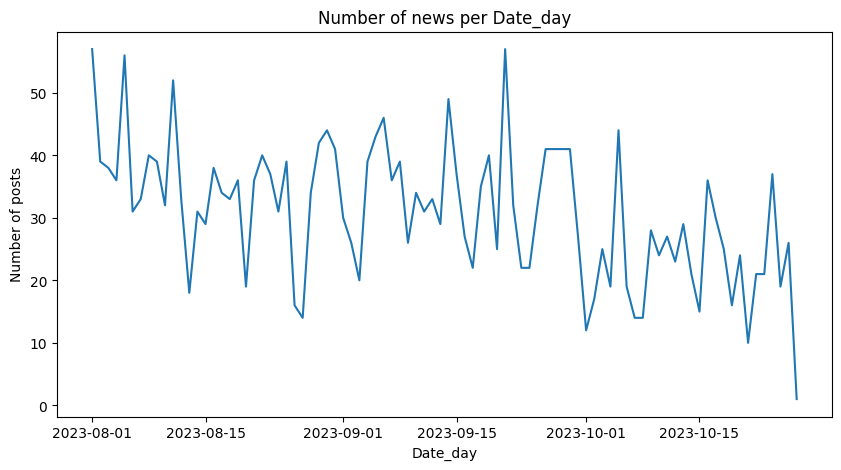

In [73]:
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

In [74]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [75]:
def read_txt_to_list(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list("/kaggle/input/kyivchennels/stopwords_ua.txt")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
add_stopwords = [
    'instagram', 'facebook', 'telegram', 'tiktok', 'viber', 'live', 'livе', 'підписатися', 'приєднатися', 'підписатись',]

stopwords = list(set(
    ru_stopwords +
    ua_stopwords +
    add_stopwords
))

In [77]:
import re

def filter_stopwords(input):
    input = nltk.tokenize.word_tokenize(input)
    input = [word for word in input if word not in stopwords]
    return " ".join(input)

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        link_pattern = r'(http\S+|www.\S+|(?:https?:\/\/)?(?:www\.)?(?:t\.me\/\S+|telegram\.me\/\S+|telegram\.dog\/\S+))'
        phone_pattern = r'\(?\+?\d{0,3}\)?[-.\s]?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{2}[-.\s]?\d{2}'

        # Compile regular expressions for better performance
        link_regex = re.compile(link_pattern)
        phone_regex = re.compile(phone_pattern)

        patterns = [
            link_regex,
            phone_regex,
            re.compile(r'[\n\t\r]'),
            re.compile(r'@\w+'),
        ]

        for pattern in patterns:
            input = pattern.sub('', input)

        emoji_pattern = re.compile(
            pattern="["
                    u"\U0001F600-\U0001F64F"  # emoticons
                    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                    u"\U0001F680-\U0001F6FF"  # transport & map symbols
                    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                    u"\U00002702-\U000027B0"
                    u"\U000024C2-\U0001F251"
                    u"\U0001f926-\U0001f937"
                    u'\U00010000-\U0010ffff'
                    u"\u200d"
                    u"\u2640-\u2642"
                    u"\u2600-\u2B55"
                    u"\u23cf"
                    u"\u23e9"
                    u"\u231a"
                    u"\u3030"
                    "]+", flags=re.UNICODE
        )
        input = emoji_pattern.sub(r'', input)

        input = re.sub(r' +', ' ', input)
        
        input = filter_stopwords(input)
        
        input = collapse_dots(input)
        
        
        
        input = input.strip()

    return input

df["content_processed"] = df["content"].apply(process_text)

<>:10: DeprecationWarning: invalid escape sequence '\.'
<>:10: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_47/2761971999.py:10: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


In [ ]:
dataset['processed_content'].sample(3).to_list()

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


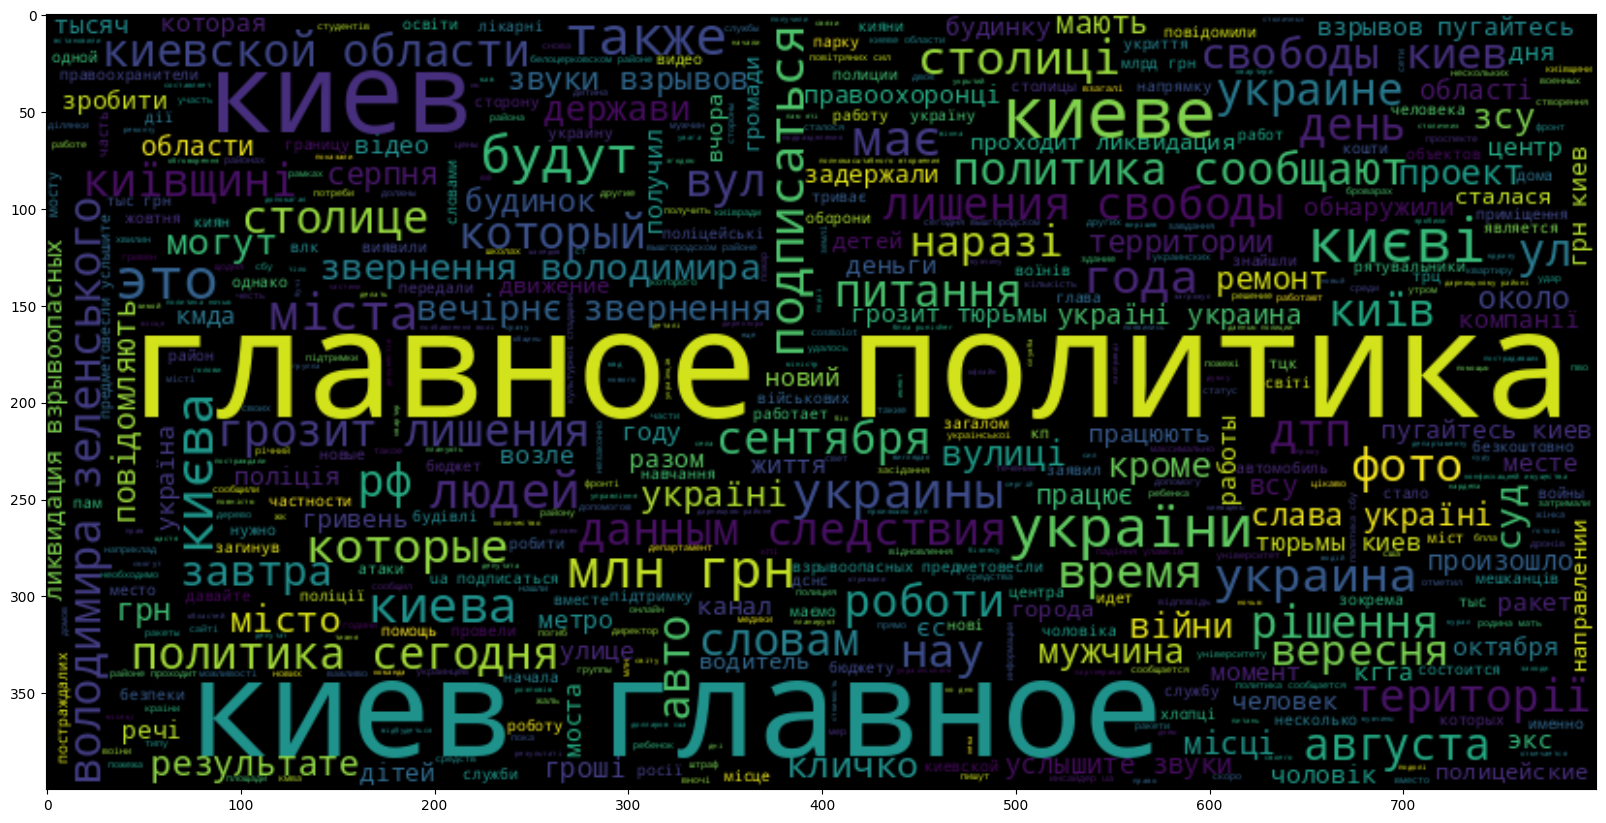

In [78]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


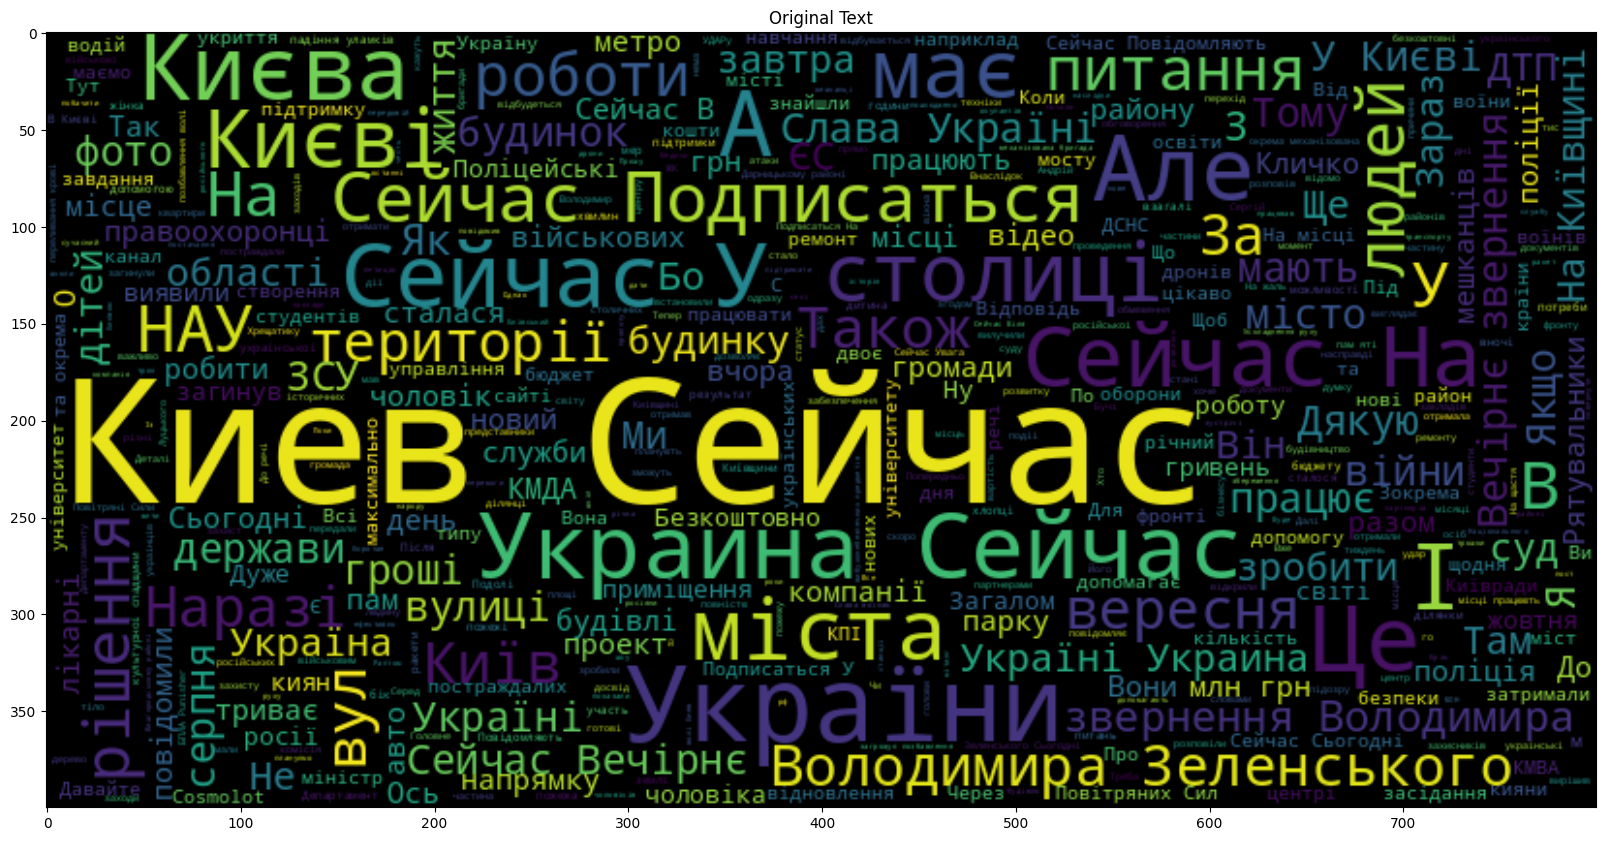

In [79]:
plt.figure(figsize=(20, 20))
plt.title("Original Text")
wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(df[df["lang"]=='uk']['content_processed']))
plt.imshow(wc, interpolation='bilinear')

/opt/conda/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


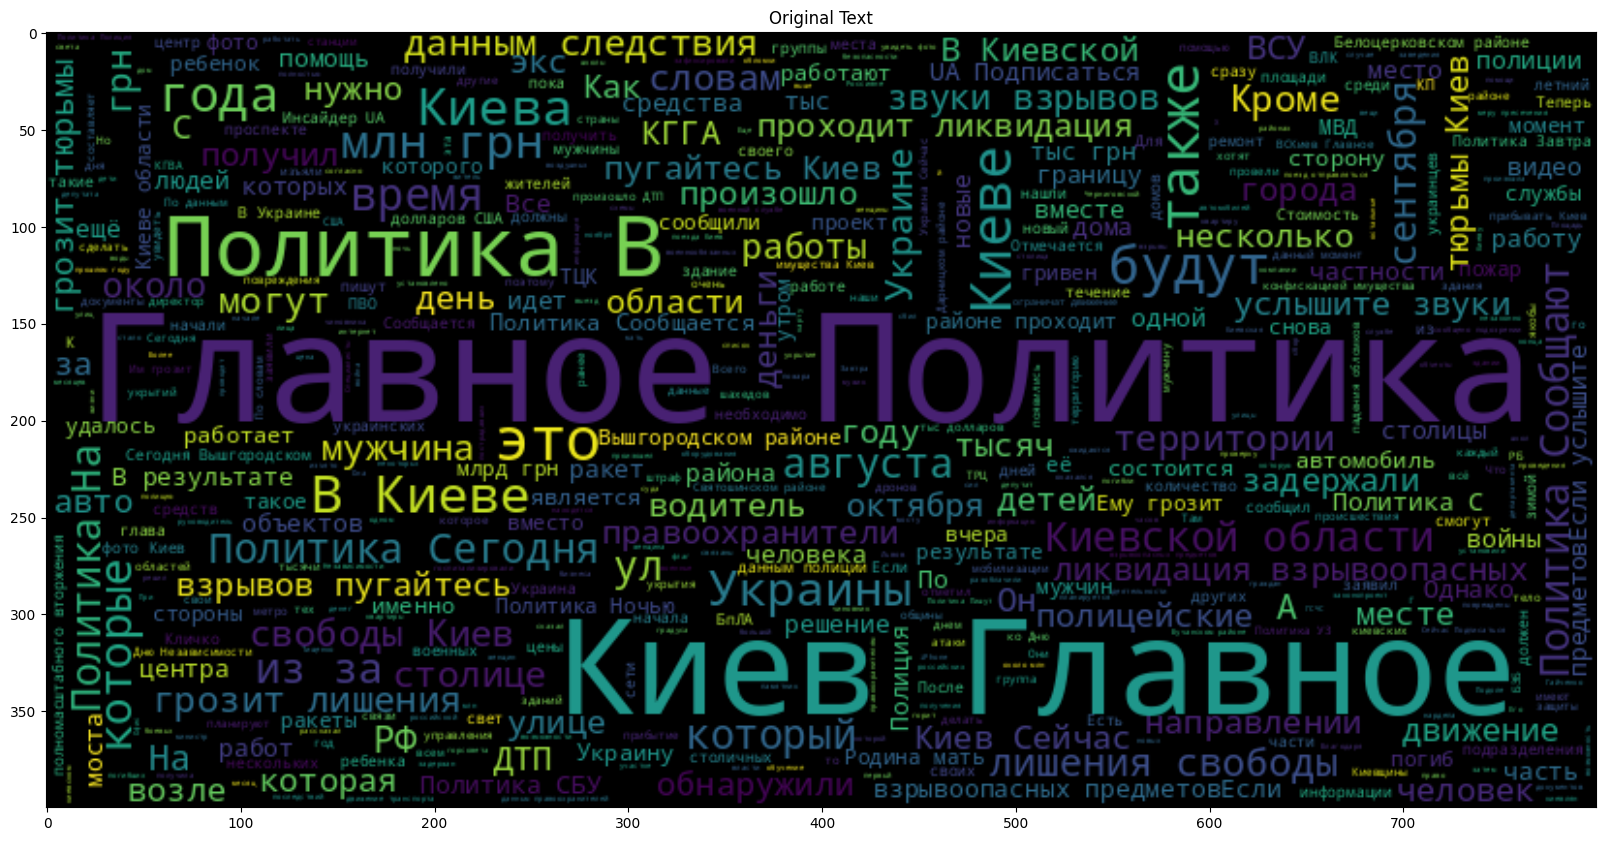

In [80]:
plt.figure(figsize=(20, 20))
plt.title("Original Text")
wc = WordCloud(max_words=500, width=800, height=400).generate(" ".join(df[df["lang"]=='ru']['content_processed']))
plt.imshow(wc, interpolation='bilinear')

## Extract Sentence embedding

In [81]:
# sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2 - maps sentences & paragraphs to a 384 dimensional dense vector space
# sentence-transformers/distiluse-base-multilingual-cased-v2 - maps sentences & paragraphs to a 512 dimensional dense vector space
# sentence-transformers/paraphrase-multilingual-mpnet-base-v2 - maps sentences & paragraphs to a 768 dimensional dense vector space
# we'll stick with mpnet-base-v2 model

sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

In [82]:
sent_embeddings = sent_emb_model.encode(df["content_processed"].to_list(), batch_size=100)

np.save(
    "KyivChannels_Dataset_v01_sent_embeddings.npy",
    sent_embeddings
)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

In [83]:
# sent_embeddings = np.load("/kaggle/input/kyivchennels/KyivChannels_Dataset_v01_sent_embeddings.npy")
assert sent_embeddings.shape[0] == df.shape[0]


# Clustering Algorithms

## Dimensionality Reduction

First of all let's explore and compare PCA, TSNE and UMAP methods for dimensionality reduction:

### PCA

In [90]:
from umap import UMAP
sent_pca = PCA().fit_transform(sent_embeddings)
sent_tsne = TSNE().fit_transform(sent_embeddings)
sent_umap = UMAP(n_neighbors=15).fit_transform(sent_embeddings)

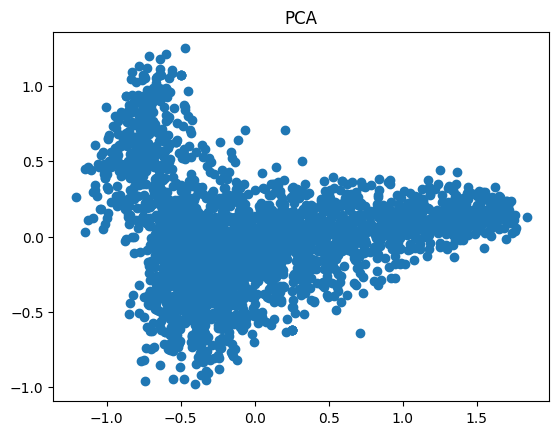

In [93]:
plt.title('PCA')
plt.scatter(sent_pca[:,0], sent_pca[:,1])

### TSNE

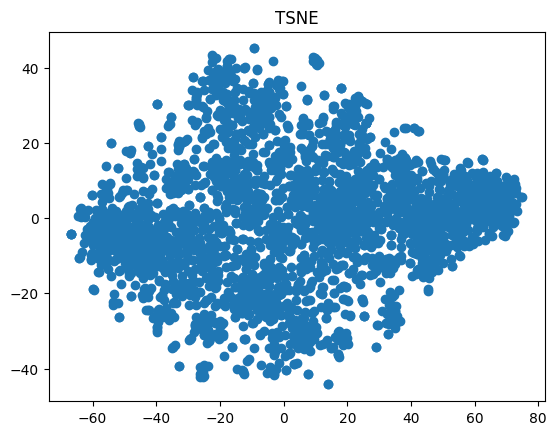

In [94]:
plt.title('TSNE')
plt.scatter(sent_tsne[:,0], sent_tsne[:,1])

### UMAP

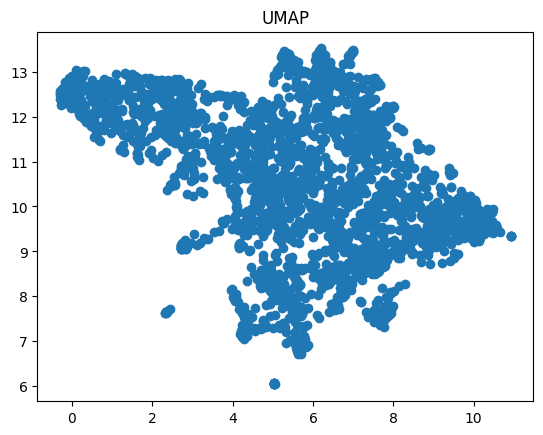

In [95]:
plt.title('UMAP')
plt.scatter(sent_umap[:,0], sent_umap[:,1])

TSNE looks kinda better(I mean we can some clusters of texts straightaway), but if we consider to use another set of channels like ['big_kyiv', 'kyivpolitics', 'darnicalive'] we may see that UMAP looks "better". This means that there is no universal dimensionality reduction technique, that will satisfy everyone.

Anyway, let's cluster our news with KMEANS, DBSCAN and HDBSCAN

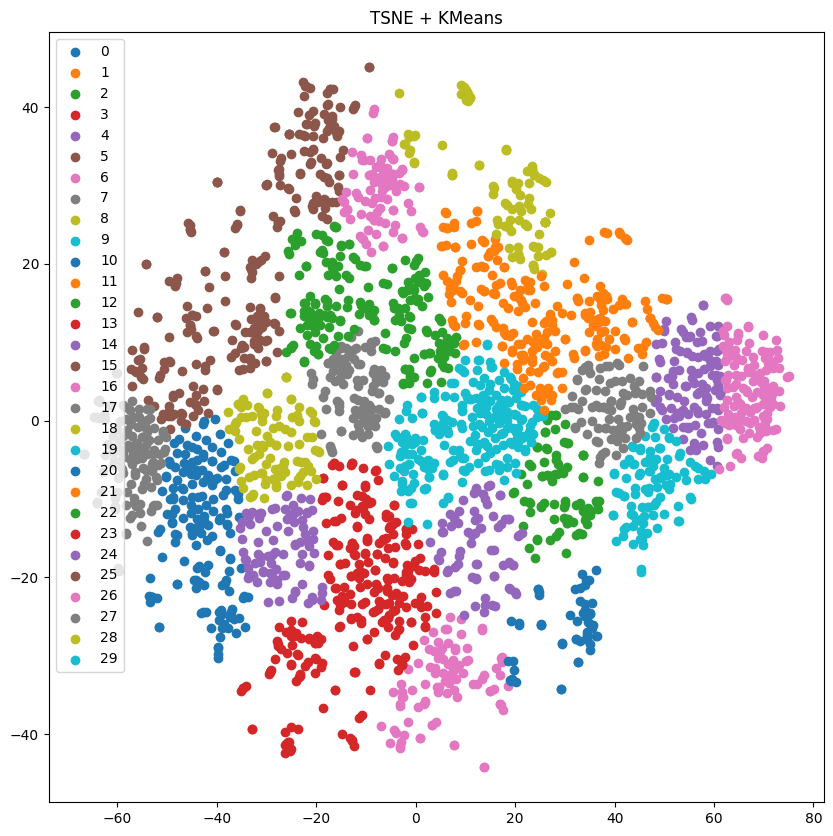

In [102]:
kmeans_clust = KMeans(
    n_clusters=30,
    random_state=42,
    init="k-means++"
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + KMeans")
for clust in np.unique(kmeans_clust):
    plt.scatter(
        sent_tsne[kmeans_clust == clust, 0],
        sent_tsne[kmeans_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

This looks not really natural. It looks like KMEANS just divided the whole corpus into 30 "districts", so I'm not sure that texts in the clusters have anything in common

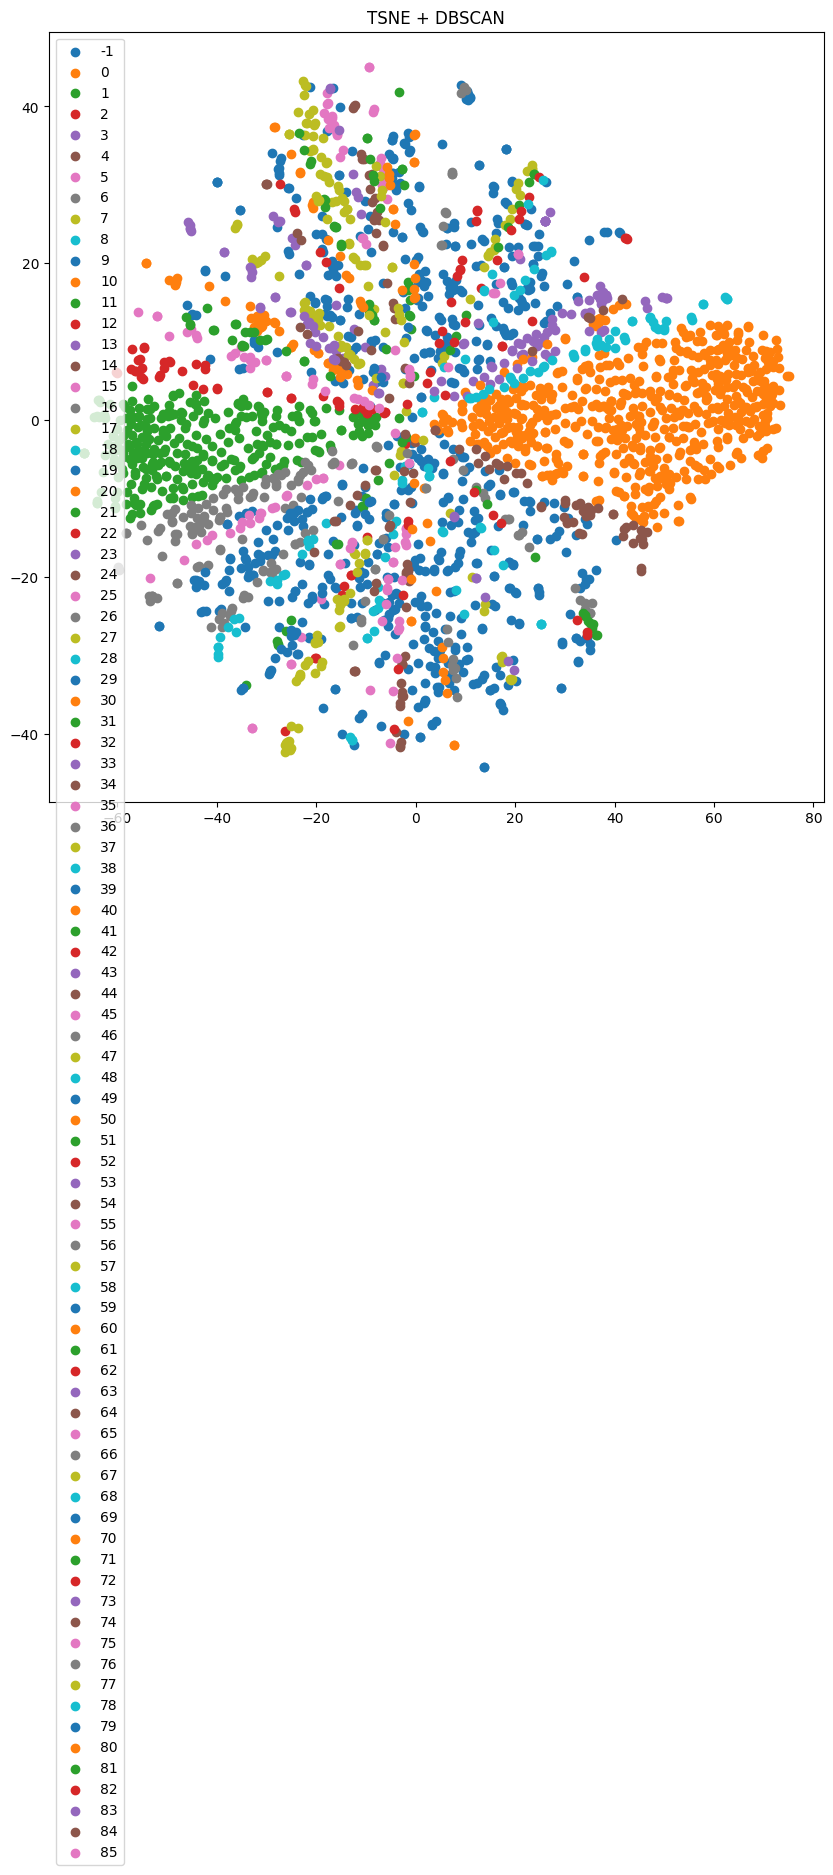

In [119]:
dbscan_clust = DBSCAN(
    eps=0.00003,
    min_samples=7,
    leaf_size=30,
    metric='cosine'
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + DBSCAN")
for clust in np.unique(dbscan_clust):
    plt.scatter(
        sent_tsne[dbscan_clust == clust, 0],
        sent_tsne[dbscan_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

Not sure if it is supposed to look like this. 

In [127]:
df[dbscan_clust == 26]['content'].sample(3).to_list()

['💪 експертна рада прийняла рішення, що весь комплекс має статус.',
 'Вчорашня дискусія про бюджет. \nНа початку багато даних про надходження і витрати від Мінфіну і Нацбанку. \n\nДуже цікаво, бо там і Київ, і Львів і Тростянець. \n\nГоловне питання – на що можна витрачати гроші під час війни. \n\nНу і мініпитання – що робити з військовим ПДФО? Деякі громади, Яворівська, наприклад, які ніколи не бачили скільки грошей в мирний час, вхопили Бога за бороду і ремонтують лижні траси) \n\nУ Києві військовий ПДФО – 6.1 мільярди. \n\nhttps://fb.watch/mkBHqv3RuM/\n\n@semenovatut',
 'Ситуація наступна. \n\nНадходження в бюджет зросли на 2.5 мільярди. \n\n914 мільйонів з ПДФО\n936 мільйонів з прибутку підприємств\n650 з єдиного податку\n\nПо платі за землю Київ отримає на 220 мільйонів менше. \n\nКуди ці гроші підуть?\n\n616 мільйонів – Київпастрансу\n624 мільйони – Метрополітену \n\n1.26 мільярдів назад в державний бюджет за програмою «Захисник Києва».\n\nПоки що процедура отримання чогось із оц

Yeah, texts in this cluster have the same topic. That's something

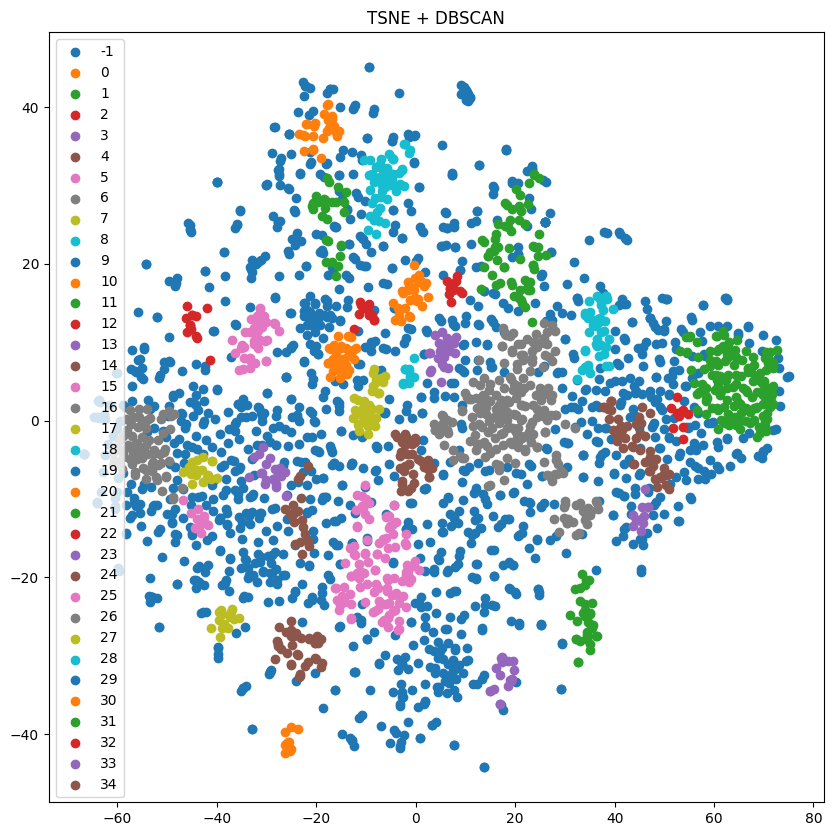

In [103]:
from hdbscan import HDBSCAN

hdbscan_clust = HDBSCAN(
    min_cluster_size=10,
    max_cluster_size=200,
).fit_predict(sent_tsne)

plt.figure(figsize=(10, 10))
plt.title("TSNE + DBSCAN")
for clust in np.unique(hdbscan_clust):
    plt.scatter(
        sent_tsne[hdbscan_clust == clust, 0],
        sent_tsne[hdbscan_clust == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

Oh! HDBSCAN looks great. Let's have a look at some examples of clustered texts

In [128]:
df[hdbscan_clust == 7]['content'].sample(5).to_list()

['У Луцького якась смішна істерика з приводу реорганізації)\n\nТому нагадаю, що там в законі. \n\nРішення про реорганізацію навчального закладу приймає засновник. \n\nЗасновник НАУ – держава в особі Кабінету міністрів. \n\nРішення при реорганізацію приймає Кабмін за поданням МОН. \n\nДа, ректора можна не питати, Вчену Раду теж. Обідно, досадно, но ладно)\n\n@semenovatut',
 'Шукаю людину, яка візьме участь в реформі НАУ. \n\nЩо робити? \nОрганізація зустрічей, ведення календаря, написання листів різним партнерам. \n\nАнглійська має бути нормальна письмова і розмовна також. \n\nВипускник чи випускниця НАУ. Якщо ми раніше перетиналися – чудово. \n\nЗарплата не з державного бюджету. \n\nПишіть.',
 'Що сказав Луцький на цьому шабаші?\n\n1. Лякає всіх наслідками реорганізації: землі роздадуть, всіх звільнять, борги льотної академії повісять на НАУ.\n\n2. Вважає що основна мета реорганізації тільки для того щоб підняти його з посади. \n\n3. Просить зробити звернення від колективу про скасуван

Geat! HDBSCAN worked correctly.

<a id='Topic_Modelling'></a>
# Topic Modelling

## LDA Model

In [129]:
all_stopwords_puncts = set(stopwords) | set(string.punctuation)

In [152]:
index_without_duplicates = df.drop_duplicates("content_processed").index
random_ids = random.sample(range(0, len(index_without_duplicates)), 100)
random_ids = index_without_duplicates[random_ids].to_list()
np.save(
    "KyivChannels_Dataset_v01_random_ids.npy",
    np.array(random_ids)
)

In [ ]:
docs = []
for d in tqdm(df.iloc[random_ids]['content_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in all_stopwords_puncts]
    )

In [ ]:
# Create Dictionary
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
# View
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

In [ ]:
# number of topics
num_topics = 40
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)
# Print the Keyword in the 40 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, vocab)
# LDAvis_prepared

## [BERTopic](https://github.com/MaartenGr/BERTopic)

In [ ]:
from bertopic import BERTopic
# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 
topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
    verbose=True
)

In [ ]:
topics, probs = topic_model.fit_transform(df.iloc[random_ids]['content_processed'].to_list())

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.get_topic(6)

In [ ]:
# topic_model.visualize_topics()